<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures](Introduction.ipynb) › Lecture 43 - Autocorrelation and AR Models
***

# Autoregressive (AR) Models

by Maxwell Margenot, Delaney Mackenzie, and Lee Tobey

Lee Tobey is the founder of Hedgewise.

## AR Models
An autoregressive, or AR$(p)$, model is created by regressing a time series on its past values, its lags. The simplest form of an autoregressive model is an AR$(1)$ model, signifying using only one lag term. A first order autocorrelation model like this for a time series $x_t$ is:

$$
x_t = b_0 + b_1 x_{t - 1} + \epsilon_t
$$

Where $x_{t - 1}$ represents the value of the time series at time $(t - 1)$ and $\epsilon_t$ is the error term. We can extend this to an AR$(p)$ model, denoted:

$$
x_t = b_0 + b_1 x_{t-1} + b_2 x_{t - 2} \ldots + b_p x_{t - p} + \epsilon_t
$$

For an AR model to function properly, we must require that the time series is covariance stationary. This means that it follows three conditions:

1. The expected value of the time series is constant and finite at all times, i.e. $E[y_t] = \mu$ and $\mu < \infty$ for all values of $t$.
2. The variance of the time series is constant and finite for all time periods.
3. The covariance of the time series with itself for a fixed number of periods in either the future or the past is constant and finite for all time periods, i.e

$$
COV(y_t, y_{t - s}) = \lambda, \  |\lambda| < \infty, \text{ $\lambda$ constant}, \  t = 1, 2, \ \ldots, T; \  s = 0, \pm 1, \pm 2, \ldots, \pm T
$$

Note that this mathematical representation includes condition 2.

If these conditions are not satisfied, our estimation results will not have real-world meaning. Our estimates for the parameters will be biased, making any tests that we try to form using the model invalid. Unfortunately, it can be a real pain to find a covariance-stationary time series in the wild in financial markets. For example, when we look at the stock price of Apple, we can clearly see an upward trend. The mean is increasing with time. There are ways, however to make a non-stationary time series stationary. Once we have performed this transformation, we can build an autoregressive models under the above assumptions.

## Simulating Data

Here we will draw data samples from a simulated AR$(3)$ process.

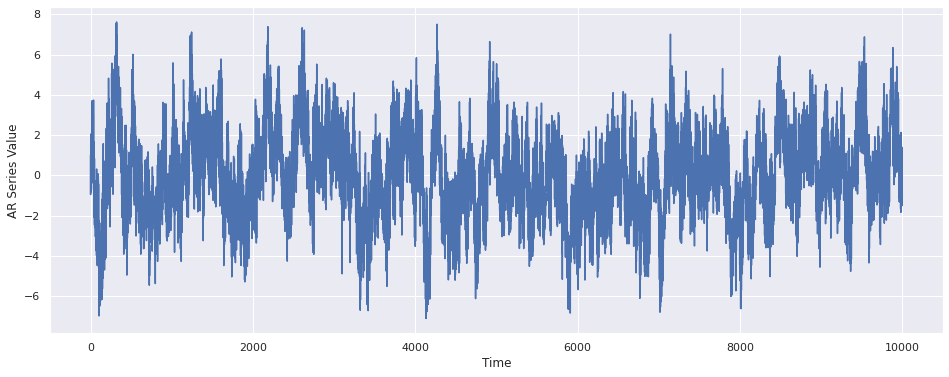

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt

# ensures experiment runs the same every time
np.random.seed(100)

# This function simluates an AR process, generating a new value based on historial values,
# autoregressive coefficients b1 ... bk, and some randomness.
def AR(b, X, mu, sigma):
    l = min(len(b)-1, len(X))
    b0 = b[0]
    
    return b0 + np.dot(b[1:l+1], X[-l:]) + np.random.normal(mu, sigma)

b = np.array([0, 0.8, 0.1, 0.05])
X = np.array([1])

mu = 0
sigma = 1

for i in range(10000):
    X = np.append(X, AR(b, X, mu, sigma))
    
plt.plot(X)
plt.xlabel('Time')
plt.ylabel('AR Series Value');

Note how this process fluctuates around some central value. This value is the mean of our time series. As we have a constant mean throughout time and the fluctuations seem to all stray within a given distance from the mean, we might hypothesize that this series is stationary. We would want to rigorously test that in practice, which we will explore lightly in the examples at the end of this lecture. Also see the Integration, Cointegration, and Stationarity lecture.

In this case, however, we have constructed the model to be stationary, so no need to worry about testing for stationarity right now.

## Tail Risk

Autoregressive processes will tend to have more extreme values than data drawn from say a normal distribution. This is because the value at each time point is influenced by recent values. If the series randomly jumps up, it is more likely to stay up than a non-autoregressive series. This is known as 'fat-tailledness' (fat-tailed distribution) because the extremes on the pdf will be fatter than in a normal distribution.

Much talk of tail risk in finance comes from the fact that tail events do occur and are hard to model due to their infrequent occurrence. If we have reason to suspect that a process is autoregressive, we should expect risk from extreme tail events and adjust accordingly.

AR models are just one of the sources of tail risk, so don't assume that because a series is non-AR, it does not have tail risk.

We'll check for that behavior now.

In [2]:
def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))    
    for k in range(4):             
        #stores tail probabilities of the sample series vs a normal series
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X        
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Compare to Gaussian distribution
    print('Frequency of std events in X \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[0]))
    print('Frequency of std events in a normal process \n1: %s\t2: %s\t3: %s\t4: %s' % tuple(A[1]))
    return A

compare_tails_to_normal(X);

Frequency of std events in X 
1: 0.32756724327567244	2: 0.18548145185481452	3: 0.09099090090990901	4: 0.0357964203579642
Frequency of std events in a normal process 
1: 0.15865525393145707	2: 0.02275013194817921	3: 0.0013498980316301035	4: 3.167124183311998e-05


## Estimations of Variance Will be Wrong

Because an AR process has a tail heavy and non-normal distribution of outcomes, estimates of variance on AR processes will be wrong. This is dangerous because variance is used to calculate many quantities in staistics, most importantly confidence intervals and p-values. Because the width of the confidence interval is often based on a variance estimate, we can no longer trust p-values that come from AR processes. For more information on p-values please see the Hypothesis Testing lecture.

Let's check this here. First we'll define some helper functions that compute a naive 95% confidence interval for the true value of the mean on some input series.

In [3]:
def compute_unadjusted_interval(X):
    T = len(X)
    # Compute mu and sigma MLE
    mu = np.mean(X)
    sigma = np.std(X)
    # Compute the bounds using standard error
    lower = mu - 1.96 * (sigma/np.sqrt(T))
    upper = mu + 1.96 * (sigma/np.sqrt(T))
    return lower, upper

# We'll make a function that returns true when the computed bounds contain 0
def check_unadjusted_coverage(X):
    l, u = compute_unadjusted_interval(X)
    # Check to make sure l <= 0 <= u
    if l <= 0 and u >= 0:
        return True
    else:
        return False
    
def simululate_AR_process(b, T):
    X = np.array([1])

    mu = 0
    sigma = 1

    for i in range(T):
        X = np.append(X, AR(b, X, mu, sigma))
        
    return X

Now we'll run an experiment 1000 times in which we compute an AR series, then estimate the mean and take a naive 95% confidence interval around it. Then we'll check if the confidence interval contains 0, the true long-term mean of our series, and record that in our `outcomes` array.

In [4]:
from IPython.display import clear_output

trials = 1000
outcomes = np.zeros((trials, 1))

for i in range(trials):
    print(f'trial {i+1} of {trials}')
    clear_output(wait=True)
    
    #note these are the same values we used to generate the initial AR array
    Z = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 100)
    if check_unadjusted_coverage(Z):
        # The internal contains 0, the true value
        outcomes[i] = 1
    else:
        outcomes[i] = 0

trial 1000 of 1000


Finally let's check, if our test is calibrated correctly, then we should have the confidence interval contain 0, 95% of the time.

In [5]:
np.sum(outcomes) / trials

0.193

Looks like something is severely wrong. What's going on here is that the AR series moves around a lot more, but the estimate of variance assumes stationarity and doesn't take into account all of that motion. As a result the confidence intervals are way smaller than they should be and don't contain the correct value nearly enough.

This gives us a false sense of security. Stationarity tests should usually catch AR behavior and let us know that estimates of variance will be wrong. For more information please see the Integration, Cointegration, and Stationarity lecture.

### Correcting for Variance

In practice it can be very difficult to accurately estimate variance on an AR series, but one attempt to do this is the Newey-West estimation. You can find information on it [here](https://en.wikipedia.org/wiki/Newey%E2%80%93West_estimator).

## Testing for AR Behavior

In order to determine the order, $p$, of an AR$(p)$ model, we look at the autocorrelations of the time series. These are the correlations of the series with its past values. The $k$-th order autocorrelation is

$$
\rho_k = \frac{COV(x_t, x_{t - k})}{\sigma_x^2} = \frac{E[(x_t - \mu)(x_{t - k} - \mu)}{\sigma_x^2}
$$

Where $k$ represents the number of periods lagged. We cannot directly observe the autocorrelations so we estimate them as 

$$
\hat{\rho}_k = \frac{\sum_{t = k + 1}^T[(x_t - \bar{x})(x_{t - k} - \bar{x})]}{\sum_{t = 1}^T (x_t - \bar{x})^2}
$$

For our purposes, we can use a pair of tools called the autocorrelation function (ACF) and the partial autocorrelation function (PACF) in order to determine the order of our model. The PACF controls for shorter lags, unlike the ACF. These functions are included with many statistical packages and compute the sample autocorrelations for us, allowing us to determine the appropriate value of $p$.

We will demonstrate these functions on our above example of a stationary series:

In [6]:
from statsmodels.tsa.stattools import acf, pacf

In [7]:
X = simululate_AR_process(np.array([0, 0.8, 0.1, 0.05]), 1000)

In [8]:
# We'll choose 40 lags. This is a bit arbitrary, but you want to include all the lags you think might
# feasibly impact the current value.
nlags = 40
# Note, this will produce nlags + 1 values, as we include the autocorrelation of
# X[-1] with X[-1], which is trivially 1.
# The reason this is done is because that is the 0th spot in the array and corresponds
# to the 0th lag of X[(-1)-0].
X_acf = acf(X, nlags=nlags, fft=False)
print('Autocorrelations:\n' + str(X_acf) + '\n')
X_pacf = pacf(X, nlags=nlags)
print('Partial Autocorrelations:\n' + str(X_pacf))

Autocorrelations:
[1.         0.57070553 0.58001725 0.88553976 0.55669882 0.57640436
 0.78307405 0.54759415 0.55254723 0.70158722 0.53082572 0.52673077
 0.62850967 0.50091633 0.48541475 0.56544198 0.46391848 0.45390828
 0.51491108 0.43375521 0.43938017 0.46783793 0.40843913 0.42270738
 0.42566802 0.38298857 0.38379558 0.40029717 0.36548704 0.36088258
 0.37743521 0.34745858 0.34065687 0.35239327 0.33194099 0.31758452
 0.33113111 0.31688646 0.2818213  0.31237461 0.31252031]

Partial Autocorrelations:
[ 1.          0.57127624  0.37827414  0.80672256  0.00162478  0.00490887
 -0.04497956  0.04013524 -0.05301909  0.00706455 -0.00528104  0.0051476
 -0.03421094 -0.03637203 -0.06841025  0.00396849 -0.02433695  0.03906542
  0.02344142  0.02958713  0.07306916 -0.01201434  0.00279546  0.01328444
 -0.00679875 -0.01547705 -0.09186641  0.05847768  0.03298422  0.04395628
 -0.01605778  0.00286143 -0.00734411 -0.01496441  0.01152254 -0.01185183
  0.01895763  0.01901218 -0.09532658  0.00791091  0.0617333

Let's plot out the values now.

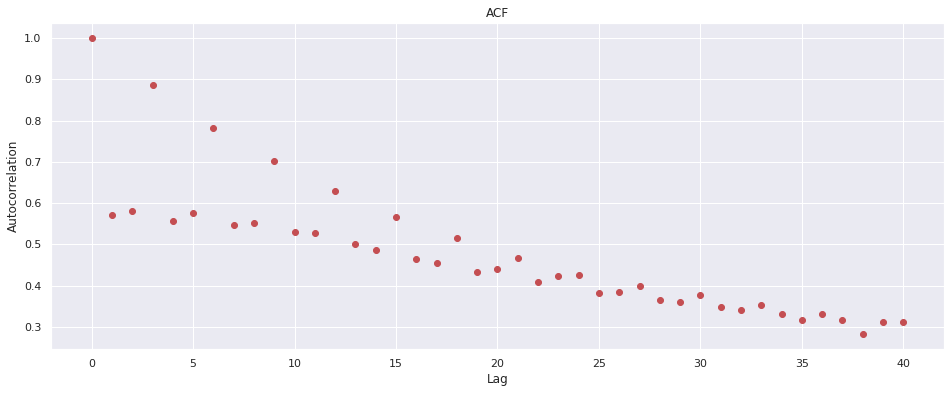

In [9]:
plt.plot(X_acf, 'ro')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title("ACF");

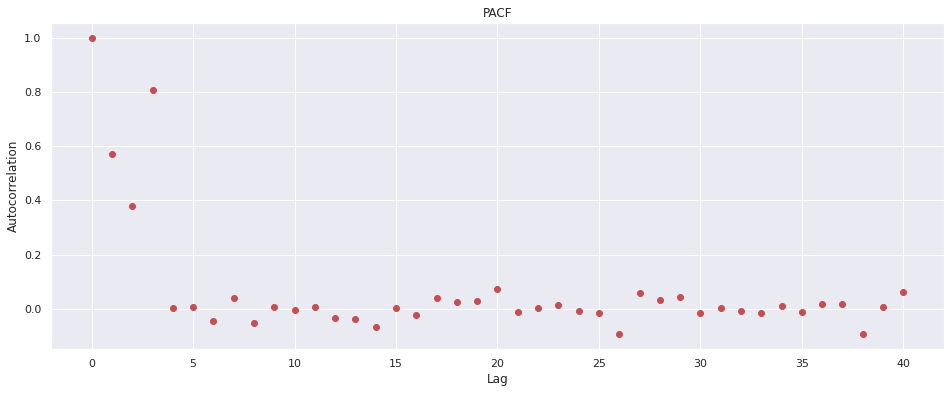

In [10]:
plt.plot(X_pacf, 'ro')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title("PACF");

### Statistical Testing

Just looking at the graphs alone isn't enough. We need to use some degree of statistical rigor. The `acf` and `pacf` functions will return confidence intervals on all the autocorrelations. We can check if these intervals overlap with zero. If they do then we say that zero is within the set confidence interval for the true parameter value, and don't treat the lag as having any meaningful autocorrelation.

NOTE: This only works if the assumptions underlying the confidence interval computations are satisfied. Please check these assumptions before you assume the test is meaningful. The assumptions will differ in every case, so please read the statistical documentation of your own test and go from there.

In [11]:
# We have to set a confidence level for our intervals, we choose the standard of 95%,
# corresponding with an alpha of 0.05.
X_acf, X_acf_confs = acf(X, nlags=nlags, alpha=0.05, fft=True)
X_pacf, X_pacf_confs = pacf(X, nlags=nlags, alpha=0.05)

After getting the confidence interval data, we'll write a function to plot it.

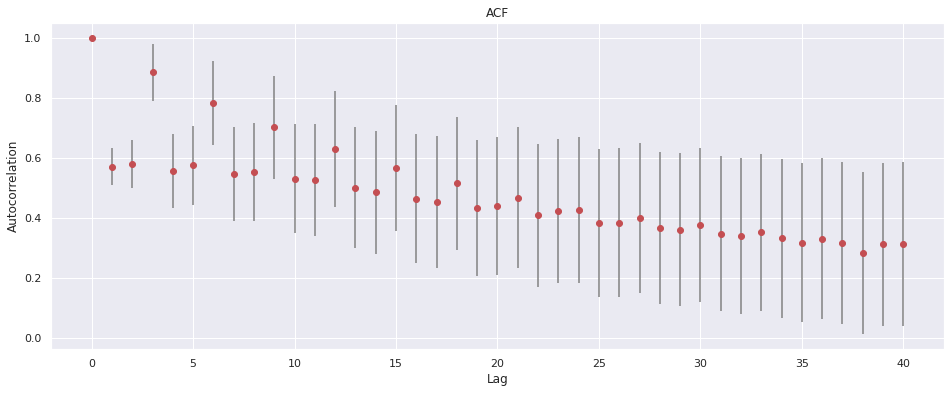

In [12]:
def plot_acf(X_acf, X_acf_confs, title='ACF'):
    # The confidence intervals are returned by the functions as (lower, upper)
    # The plotting function needs them in the form (x-lower, upper-x)
    errorbars = np.ndarray((2, len(X_acf)))
    errorbars[0, :] = X_acf - X_acf_confs[:,0]
    errorbars[1, :] = X_acf_confs[:,1] - X_acf

    plt.plot(X_acf, 'ro')
    plt.errorbar(range(len(X_acf)), X_acf, yerr=errorbars, fmt='none', ecolor='gray', capthick=2)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title);
plot_acf(X_acf, X_acf_confs)

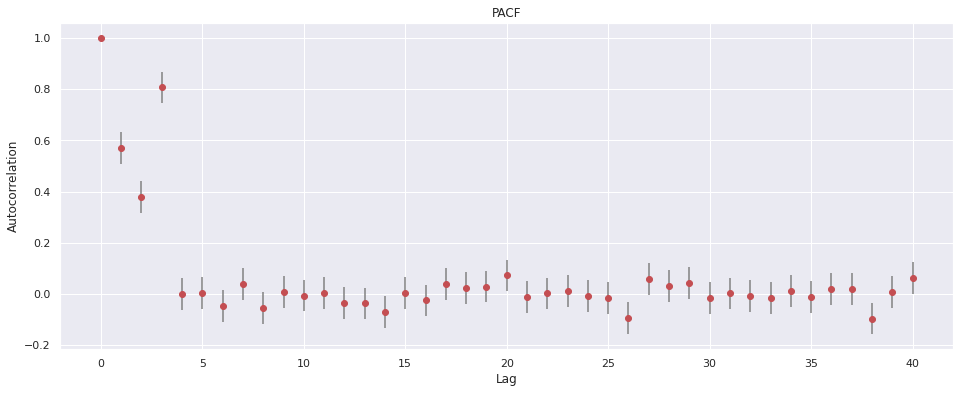

In [13]:
plot_acf(X_pacf, X_pacf_confs, title='PACF')

Notice how for the PACF, the first three lags are the only ones that appear to be significantly different from $0$, which makes sense because we directly constructed an AR model of order $3$. However, these results may vary for each random series generated in this notebook.


In a real-world time series, we use these plots to determine the order of our model. We would then attempt to fit a model using a maximum likelihood function.

## Fitting a Model

We'll use one of the functions already implemented in Python to fit an AR model. We'll try this on our simulated data first.

In [14]:
# Construct an unfitted model
model = tsa.api.AutoReg(X, lags=nlags)
# Fit it
model = model.fit()

The `model` object has a lot of useful information on it, use the `?` notation to find out more. We'll be focusing on a few attributes, starting with `model.params` the estimated parameters in the model, one for each lag, and `model.bse`, the estimated standard error for each of the parameters.

In [15]:
print('Parameters')
print(model.params)
print('Standard Error')
print(model.bse)

Parameters
[ 0.01724111  0.04515804  0.07437131  0.85070648 -0.02068638  0.06252601
 -0.04111677  0.05337118 -0.06284995  0.02593036  0.01904109  0.05997752
 -0.03681612 -0.01146089 -0.08617622 -0.01072612 -0.06439772 -0.03987813
  0.01682804  0.04147587  0.06590082  0.01157124  0.00395936  0.10229544
 -0.05514214 -0.03724592 -0.14138476  0.06610644  0.03248547  0.05314844
 -0.01397308 -0.01714909 -0.00974412 -0.02109196  0.00723587  0.06845649
  0.02226561 -0.01984467 -0.09665417  0.00383139  0.05296155]
Standard Error
[0.03164671 0.03218896 0.03222577 0.0321575  0.04226242 0.04228592
 0.04227559 0.0423044  0.04236335 0.04244231 0.0424578  0.04246112
 0.0424676  0.0424941  0.04243313 0.04216485 0.04214158 0.04217838
 0.04205653 0.04202755 0.04215054 0.0421432  0.04214668 0.04214695
 0.04225594 0.04226372 0.04221868 0.04234144 0.04239355 0.04236347
 0.04231471 0.04231873 0.04231697 0.04224398 0.04216363 0.04214003
 0.0420803  0.04205891 0.03206092 0.03211749 0.03207347]


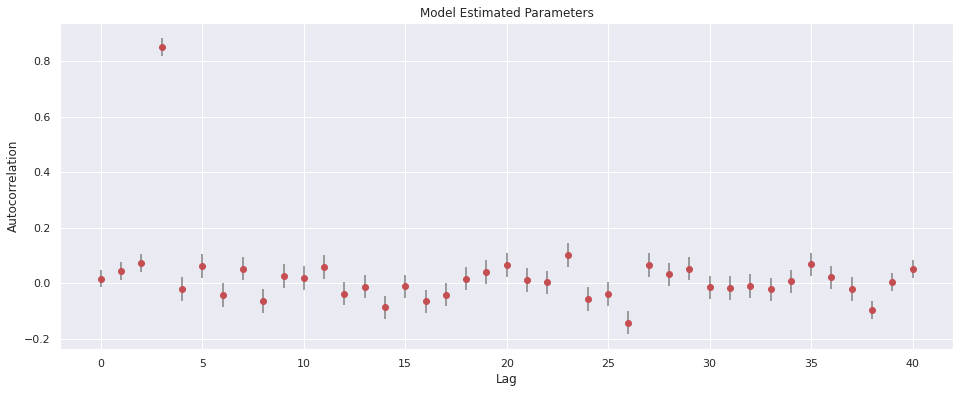

In [16]:
# To plot this we'll need to format a confidence interval 2D array like the previous functions returned
# Here is some quick code to do that
model_confs = np.asarray((model.params - model.bse, model.params + model.bse)).T

plot_acf(model.params, model_confs, title='Model Estimated Parameters')

### Choosing the Number of Lags

#### Estimations Will Yield Too Many Lags

We can see our model estimated quite a few parameters. In this case we know there are too many because we simulated the data as an AR(3) process. The reason that AR models will estimate many more lags than is actually the case is due to indirect dependency. If $X_t$ depends on $X_{t-1}$, then indirectly and to a lesser extent it will depend on $X_{t-2}$. In the presence of more than one lag in the data generating process, we will get potentially complex harmonic structures in the lags. These indirect dependencies will be picked up by a simple estimation.

#### You Want the Fewest Parameters That Yield a Decent Model

In general it's rarely the case that you can get anything useful out of a model with many parameters, see the Overfitting lecture for why. In this case we want to select a number of lags that we believe explains what is happening, but without overfitting and choosing a model with way too many lags. 

Observing the ACF and PACF indicates that only the first 3 lags may be useful. However, we will expand the number of lags to 10 to double-check our initial data. We will use information criterion, specifically Akaike Information Criterion (AIC) and Bayes Information Criterion (BIC) to decide the correct number of parameters.

Interpreting the AIC and BIC is done as follows. Compute the AIC and BIC for all models we wish to consider, and note the smallest AIC and BIC recorded $AIC_{min}$ and $BIC_{min}$. These are the models which minimize information loss under each metric. For each type of IC we then can compute the *relative likelihood* of each model $i$ by taking 

$$l = e^{(IC_{min} - IC_{i})/2}$$

We can interpret $l$ as model $i$ is $l$ times as likely to minimize information loss, compared to the minimum AIC model. It might take a few reads to understand this, so let's just see it in action.

In [17]:
N = 10
AIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AutoReg(X, lags=i+1)
    model = model.fit()
    AIC[i] = model.aic
    
AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print('Relative Likelihoods')
print(np.exp((AIC_min-AIC) / 2))
print('Number of parameters in minimum AIC model %s' % (model_min+1))

Relative Likelihoods
[[0.54739169]
 [0.59052713]
 [0.99861675]
 [0.997749  ]
 [0.99628437]
 [0.99619915]
 [0.9960884 ]
 [1.        ]
 [0.99850924]
 [0.99809322]]
Number of parameters in minimum AIC model 8


In [18]:
N = 10
BIC = np.zeros((N, 1))

for i in range(N):
    model = tsa.api.AutoReg(X, lags=i+1)
    model = model.fit()
    BIC[i] = model.bic
    
BIC_min = np.min(BIC)
model_min = np.argmin(BIC)

print('Relative Likelihoods')
print(np.exp((BIC_min-BIC) / 2))
print('Number of parameters in minimum BIC model %s' % (model_min+1))

Relative Likelihoods
[[0.5508575 ]
 [0.59280494]
 [1.        ]
 [0.99666667]
 [0.99274501]
 [0.99020386]
 [0.98763995]
 [0.98905709]
 [0.9851272 ]
 [0.98226451]]
Number of parameters in minimum BIC model 3


Our conclusion is that the AIC estimates the 4 parameter model as most likely, whereas the BIC estimates 3. Because we are always looking for reasons to knock off a parameter, we choose the 3. In this case it happened to be the exact right answer, but this will not always be the case, especially in noisy real data. Don't assume that using this method will always get you the right answer.

### Evaluating Residuals

One final step we might do before performing an out of sample test for this model would be to evaluate its residual behavior. The AIC and BIC already do this to an extent, effectively measuring how much information is left on the table (in the residuals) after the model has made its predictions. For more information on residuals analysis see the Violations of Regression Models lecture. Here we'll just check for normality of the residuals.

In [19]:
model = tsa.api.AutoReg(X, lags=3)
model = model.fit()

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(model.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

The residuals seem normally distributed.


The residuals seem normally distributed. There are more model validation steps that could be done, but these are the core ones for an AR model. The next steps would be testing the model out of sample, and then using it to make predictions on your data.

## References
* "Quantitative Investment Analysis", by DeFusco, McLeavey, Pinto, and Runkle
* "Analysis of Financial Time Series", by Ruey Tsay

---

**Next Lecture:** [ARCH, GARCH, and GMM](Lecture44-ARCH-GARCH-and-GMM.ipynb)

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*